# Studies on solving Kakuro puzzle with Grover algorithm

Valter Uotila, PhD student, University of Helsinki

Note: if you rerun specific cells without restarting the kernel, there might be unexpected behavior and errors in how the notebook handles the variables.

As the discussion in Classiq's channel showed, this problem has been somewhat confusing. If we read the problem definition very carefully, it does not describe what kind of Grover algorithm application it should be. For example, saying ''You are not allowed to solve the puzzle manually'' seems to be meaning actual manual solving by the person. On the other hand, it could also mean that any classical preparation is not allowed. Still, the discussion forum also hints that it is sufficient to encode the constraints in Grover's oracle, which is, in my opinion, a lot easier task than writing an oracle that genuinely solves the puzzles.

Not caring so much about the exact problem, I developed various solutions to the challenge. First, I represent the solution that I consider interesting in how it encodes the variables and values. Instead of using a massive number of qubits, we should design algorithms to take advantage of the exponentially growing space of states. Hilbert's space is indeed large, and we should benefit from that. The first solution's downside is that it is not precisely Grover's algorithm that solves the problem. In my opinion, Grover's algorithm instead reads quantumly encoded solution from the black box oracle circuit. That is in line with Grover's original idea of finding the marked element from an unsorted list. Now it depends on the problem definition if this is allowed or not. I developed the solution so that you can input any (there must be some corner cases that fail) Kakuro problem. Then the algorithm classically creates the oracle, and Grover's algorithm ''reads'' the solution from the oracle.

The second solution follows the idea that is also represented in Qiskit documentation: [Solving Sudoku using Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html#5.-Solving-Sudoku-using-Grover's-Algorithm-). I believe that this is the idea that has been in the developers' minds while designing the Kakuro challenge. Grover's algorithm solves the problem unlike the previous case, but the downside is the circuit's large qubit number and depth. 

I partly participate in the competitions because they motivate me to study new topics efficiently. I also wanted to consider the third option based on an exciting paper: [Grover Adaptive Search for Constrained Polynomial Binary Optimization](https://arxiv.org/abs/1912.04088).

Table of contents:
- Solution proposal 1: Qubit and gate efficient approach following Grover's original idea
- Solution proposal 2: Apply idea from Qiskit documentation
- Solution proposal 3: Apply ideas from paper _Grover Adaptive Search for Constrained Polynomial Binary Optimization_

## Transforming integer variables into binary variables

The notebook utilizes a spesific binary variable encoding. Let us assume that we have $n$ variables $x_i$ for $i = 0, \ldots, n - 1$. To have consistent notation we start indexing from $0$. Now each of these variables can have a value $0,1,2,3$. In order to express to problem using the binary variables, we define binary variables $x_{i, j}$ so that $i = 0, \ldots, n - 1$ and $j \in \left\{0,1,2,3 \right\}$. The interpretation of the binary variables is simple: $x_{i,j} = 1$ if $x_i = j$. This enables us to encode integers into binary model. We have $4n$ binary variables in the final model.

## Solution proposal 1: Qubit and gate efficient approach following Grover's original idea

The first idea of how to tackle the challenge is to assign a state for each binary variable $x_{i,j}$. In the end, if we measure $x_{i,j} = 1$, we know that $x_i = j$. For example, the variable $x_{0,0}$ can correspond to the state $|0000\rangle$ in the case $n = 4$. Because the number of states grows exponentially, we would be able to represent large problems with a small number of qubits. If we can transform the constraints into Grover oracle, which favors those states that correspond to the problem's solution, this would solve the problem. Anyway, constructing such an oracle generally seems a complicated task.

For me, this exercise shows an exciting and also confusing point about quantum oracles. Usually, quantum oracles encode the problems that we are solving. Oracles are black-box. In that sense, in this solution proposal, the quantum computer is just a machine that we use to read the result from the oracle.

### Studying constraint types

We can divide the constaints into two classes. Because I want to be able to code the solution so that anyone without thinking anything simply inputs Kakuro constraints from the problem, I start by considering the simple example case from the problem definition:
$$
\begin{align}
x_0 \neq & x_1 &\quad x_0 \neq& x_2 \\
x_1 \neq & x_3 &\quad x_2 \neq& x_3 \\
x_0 + x_1 =& 3 &\quad x_0 + x_2 =& 3 \\
x_2 + x_3 =& 4 &\quad x_1 + x_3 =& 4.
\end{align}
$$

#### Constraint type 1: inequality between two variables

Obviously the first class of constraints is
$$
\begin{align}
x_0 \neq & x_1 \\
x_2 \neq& x_3 \\
x_0 \neq& x_2 \\
x_1 \neq & x_3.
\end{align}
$$

Let's focus on the first constraint $x_0 \neq x_1$. In the binary variable format, this constraint means that if $x_{i,j} = 1$ then $x_{k,j} = 0$ for $i = 0, 1$, $k = 0, 1$, $i \neq k$ and for $j = 0,1,2,3$. In other words, if we flip the phase of the state corresponding the variable $x_{0,j}$ (meaning it is part of the solution), then we are not allowed to flip variable $x_{1,j}$. If we were to flip the both variables, then it would mean $x_0 = j = x_1$ which is not allowed. This analysis shows that we have multiple options how to flip the states corresponding the variables.

So we proceed so that we initially create all the possible correct circuits for the constraint $x_0 \neq x_1$. Then we proceed to the next constraint $x_2 \neq x_3$ and append the possible options to the circuits produced in the previous step. At each appending phase, we check if some of the previous constraints are violeted. If a constraint is violeted, we drop the circuit from the process. Finally, we are left with Grover oracles that produce the correct solution to the problem. Note that this process produces all the correct circuit and for this simple example there are two of them.

#### Constraint type 2: sum of variables with equality to constant 

Clearly the second class of constraints is
$$
\begin{align}
x_0 + x_1 =& 3 \\
x_2 + x_3 =& 4 \\
x_0 + x_2 =& 3 \\
x_1 + x_3 =& 4.
\end{align}
$$

Again, let's focus on the constraint $x_0 + x_1 = 3$. This means that we have two variables whose values sum up to three. We can divide this into multiple cases:

- $x_0 = 0$ and $x_1 = 3$
- $x_0 = 3$ and $x_1 = 0$
- $x_0 = 1$ and $x_1 = 2$
- $x_0 = 2$ and $x_1 = 1$

Luckily variables can hold numbers only up to three so maximum value that we can face on the right-hand side of the equality is $6$. Also, it is safe to assume that we do not sum more than three variables at the time and all the variables are different since they appear on the same row or column in the puzzle. This reduces the number of combinations.

Let's study the case that we want to encode $x_0 = 0$ and $x_1 = 3$. This means that we want to set $x_{0,0} = 1$ and $x_{1,3} = 1$ as binary variables. If we have encoded some constraints before this constraint, flipping the states of these variables might violate some previous constraints. That allows us to drop certain oracles from the construction process. Now we are only left to concretely code this approach.

### Implementation

This notebook utilizes three large quantum coding packages: Qiskit, Pennylane and Ocean. Besides, we are utilizing Pennylane's Cirq and Braket plugins as well as Braket plugin for Ocean.

In [1]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install matplotlib

#!{sys.executable} -m pip install pennylane
#!{sys.executable} -m pip install qiskit
#!{sys.executable} -m pip install dwave-ocean-sdk

#!{sys.executable} -m pip install amazon-braket-sdk
#!{sys.executable} -m pip install amazon-braket-pennylane-plugin
#!{sys.executable} -m pip install pennylane-cirq

In [2]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.standard_gates import MCXGate, XGate, CCXGate, TGate
import numpy as np
import copy

If we concentrate the main problem, the constraints are 

$$
\begin{align}
x_0 &\neq x_1 &\quad x_0 &\neq x_2 &\quad x_1 &\neq x_3 \\
x_1 &\neq x_5 &\quad x_2 &\neq x_3 &\quad x_2 &\neq x_4 \\
x_3 &\neq x_4 &\quad x_3 &\neq x_5 &\quad x_4 &\neq x_6 \\
x_5 &\neq x_6 &&&& \\
x_0 + x_2 &= 5 &\quad x_1 + x_3 + x_5 &= 3 &\quad x_4 + x_6 &= 1 \\
x_2 + x_3 + x_4 &= 5 &\quad x_0 + x_1 &= 3 &\quad x_5 + x_6 &= 1.
\end{align}
$$

For four variables we have $4*4 = 16$ binary variables which requires $16$ states so we need exactly four query qubits in Grover's algorithm. For six variables we need five query qubits.

You can uncomment and comment the cells below depending on which Kakuro puzzle you want to execute.

In [3]:
# Development and debugging purposes

#query_qubits = 4
#n_variables = 4

#inequality_constraints = [(0,1), (2,3), (1,3), (0,2)]
#sum_equality_constraints = [{'variables': [0, 1], 'sum': 3}, {'variables': [2, 3], 'sum': 4}, {'variables': [0, 2], 'sum': 3}, {'variables': [1, 3], 'sum': 4}]

In [4]:
# Classicq's actual Kakuro puzzle

query_qubits = 5
n_variables = 7

inequality_constraints = [(0,1), (0,2), (1,3), (1,5), (2,3), (2,4), (3,4), (3,5), (4,6), (5,6)]
sum_equality_constraints = [{'variables': [0, 2], 'sum': 5}, {'variables': [1, 3, 5], 'sum': 3}, {'variables': [4, 6], 'sum': 1}, {'variables': [2, 3, 4], 'sum': 5}, {'variables': [0, 1], 'sum': 3}, {'variables': [5, 6], 'sum': 1}]

The following injective function maps the binary variables $x_{i,j}$ to integers whose binary representations correspond to states. We return the binary representation as a list since we will need to access each element in the representation later.

In [5]:
def variable_to_state(i,j):
    int_repr = 4*i + j
    bin_repr = np.binary_repr(int_repr)
    return '0'*(query_qubits - len(bin_repr)) + bin_repr


def state_to_variable(state):
    decimal = int(state, 2)
    j = decimal % 4
    i = int(np.floor(decimal/4))
    return (i, j)

In [6]:
# Encodes if x_3 = 2 i.e. x_3 = 2 is True if |1110> is True after measurement 
print(variable_to_state(3,2))
print(state_to_variable(variable_to_state(3,2)))

01110
(3, 2)


We proceed with the following idea: Every constraint induces options how to flip phases. Whatever we inlcude in the circuit, we need to exclude something. Consider the example if $x_{0,1} = 1$ then $x_{1,1} = 0$. When we include the gate that encodes the solution $x_{0,1} = 1$, then we cannot use the gate encoding $x_{1,1} = 1$ at any part of the circuit later. This process reduces the correct oracles.

In [7]:
def compose_phase_flip_gate(i, j, circuit):
    ctrl = variable_to_state(i,j)
    circuit.add(ctrl)
    return circuit


def expand_inequality_oracles(x, y, oracles):
    new_oracles = []
    for oracle in oracles:
        for j in range(4):
            oracle_copy = copy.deepcopy(oracle)
            bin_table = oracle_copy['bin_table']
            if bin_table[x][j] != -1 and bin_table[y][j] != 1:
                bin_table[x][j] = 1
                for k in range(4):
                    if k != j:
                        bin_table[x][k] = -1
                bin_table[y][j] = -1
                circuit = oracle_copy['circuit']
                compose_phase_flip_gate(x, j, circuit)
                new_oracles.append(oracle_copy)
    return new_oracles


def initialize_oracles(x, y, oracles):
    for j in range(4):
        circuit = compose_phase_flip_gate(x, j, set())
        bin_table = np.zeros(shape=(n_variables, 4))
        bin_table[x][j] = 1
        for k in range(4):
            if k != j:
                bin_table[x][k] = -1
        bin_table[y][j] = -1
        oracles.append({'circuit': circuit, 'bin_table' : bin_table })
    return oracles


def create_inequality_oracles(constraints):
    oracles = []
    x = constraints[0][0]
    y = constraints[0][1]
    oracles = initialize_oracles(x, y, oracles)
    oracles = initialize_oracles(y, x, oracles)
    
    for constraint in constraints[1:]:
        x = constraint[0]
        y = constraint[1]
        oracles = expand_inequality_oracles(x, y, oracles)
        oracles = expand_inequality_oracles(y, x, oracles)
    return oracles

In [8]:
oracles = create_inequality_oracles(inequality_constraints)
# print(len(oracles))

The following function calculates how many different ways we can sum two or three variables so that we obtained the given sum. We can exclude the cases when there are two equal number in the sum since these cases will always violate some of the inequality constraints.

In [9]:
def sum_options(constraint):
    variables = constraint['variables']
    sum_value = constraint['sum']
    result = []
    
    if len(variables) == 2:
        for i in range(4):
            if sum_value - i < 4 and sum_value - i > -1:
                if i != sum_value - i:
                    result.append((i, sum_value - i))
    elif len(variables) == 3:
        for i in range(4):
            if sum_value - i < 4 and sum_value - i > -1:
                options = sum_options({'variables': [0, 1], 'sum': i})
                for o in options:
                    if (sum_value - i) != o[0] and (sum_value - i) != o[1] and o[0] != o[1]:
                        result.append((sum_value - i, o[0], o[1]))
                        result.append((o[0], sum_value - i, o[1]))
                        result.append((o[0], o[1], sum_value - i))
                
    return list(set(result))

In [10]:
print(sum_options({'variables': [2, 3, 4], 'sum': 3}))
#print(sum_options({'variables': [2, 3, 4], 'sum': 4}))
#print(sum_options({'variables': [2, 3, 4], 'sum': 5}))
#print(sum_options({'variables': [2, 3, 4], 'sum': 6}))
#print()
print(sum_options({'variables': [0, 1], 'sum': 1}))
#print(sum_options({'variables': [0, 1], 'sum': 2}))
#print(sum_options({'variables': [0, 1], 'sum': 3}))
#print(sum_options({'variables': [0, 1], 'sum': 4}))
#print(sum_options({'variables': [0, 1], 'sum': 5}))

[(0, 2, 1), (1, 2, 0), (2, 1, 0), (2, 0, 1), (0, 1, 2), (1, 0, 2)]
[(0, 1), (1, 0)]


We then update the binary variable tables and the corresponding circuits based on the different combinations that summing creates.

In [11]:
def limit_oracles_based_on_sum_constraints(sums, constraint, oracles):
    correct_oracles = []
    variables = constraint['variables']
    for oracle in oracles:
        for option in sums:
            bin_table = oracle['bin_table']
            if all([bin_table[variables[k]][option[k]] == 1 for k in range(len(variables))]):
                correct_oracles.append(oracle)
    return correct_oracles
    

def build_sum_oracle(constraint, oracles):
    sums = sum_options(constraint)
    oracles = limit_oracles_based_on_sum_constraints(sums, constraint, oracles)
    return oracles

In [12]:
for constraint in sum_equality_constraints:
    oracles = build_sum_oracle(constraint, oracles)
    #print(len(oracles))

In [13]:
def remove_duplicates(oracles):
    new_oracles = [oracles[0]]
    for oracle in oracles[1:]:
        if not any([np.array_equal(oracle['bin_table'], oracle2['bin_table']) for oracle2 in new_oracles]):
            new_oracles.append(oracle)
    return new_oracles

In [14]:
oracles = remove_duplicates(oracles)

#print(oracles)
#for b in oracles[0]['circuit']:
#    print(state_to_variable(b))

### Implement Grover search

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram

In [16]:
def initialize(qc, qubits):
    qc.x(qubits[-1])
    qc.h(qubits)
    return qc

The following function creates the oracle for the correct states.

In [17]:
def compose_grover_oracle(qc, qubits, ctrl_char):
    not_indices = []
    qc.barrier()
    for i, b in enumerate(ctrl_char):
        if b == '0':
            qc.x(len(qubits) - 2 - i)
            not_indices.append(len(qubits) - 2 - i)
            
    qc.mcx(list(qubits[:-1]), len(qubits) - 1)
    
    for i in not_indices:
        qc.x(i)
    return qc

In [18]:
def diffusion(qc, qubits):
    qc.barrier()
    qc.h(qubits)
    qc.x(qubits[:-1])
    qc.mcx(list(qubits[:-1]), len(qubits) - 1)
    qc.x(qubits[:-1])
    qc.h(qubits)
    return qc

The algorithm provides all the possible answers to the puzzle. The main Kakuro seems to have just single solution but the another example has two solutions. The both are run on a noisy simulator. In both cases just one oracle call seems sufficient. 

In [19]:
final_circuits = []

for oracle in oracles:
    grover_circuit = QuantumCircuit(query_qubits + 1, query_qubits)
    grover_circuit = initialize(grover_circuit, range(query_qubits + 1))
    
    for ctrl_char in oracle['circuit']:
        grover_circuit = compose_grover_oracle(grover_circuit, range(query_qubits + 1), ctrl_char)

    grover_circuit = diffusion(grover_circuit, range(query_qubits + 1))
    final_circuits.append(grover_circuit)

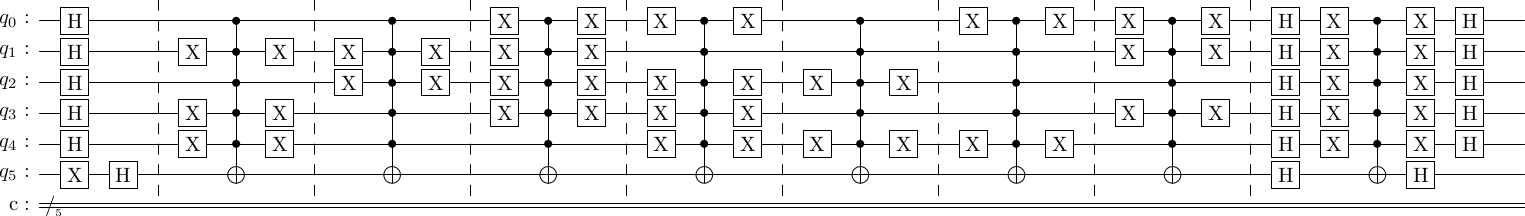

In [20]:
final_circuits[0].draw(output='latex')

In [21]:
solution_counts = []
for grover_circuit in final_circuits:
    grover_circuit.measure(range(query_qubits), range(query_qubits))
    aer_sim = Aer.get_backend('aer_simulator', )
    qobj = assemble(grover_circuit)
    result = aer_sim.run(qobj, shots=100000).result()
    counts = result.get_counts()
    solution_counts.append(counts)

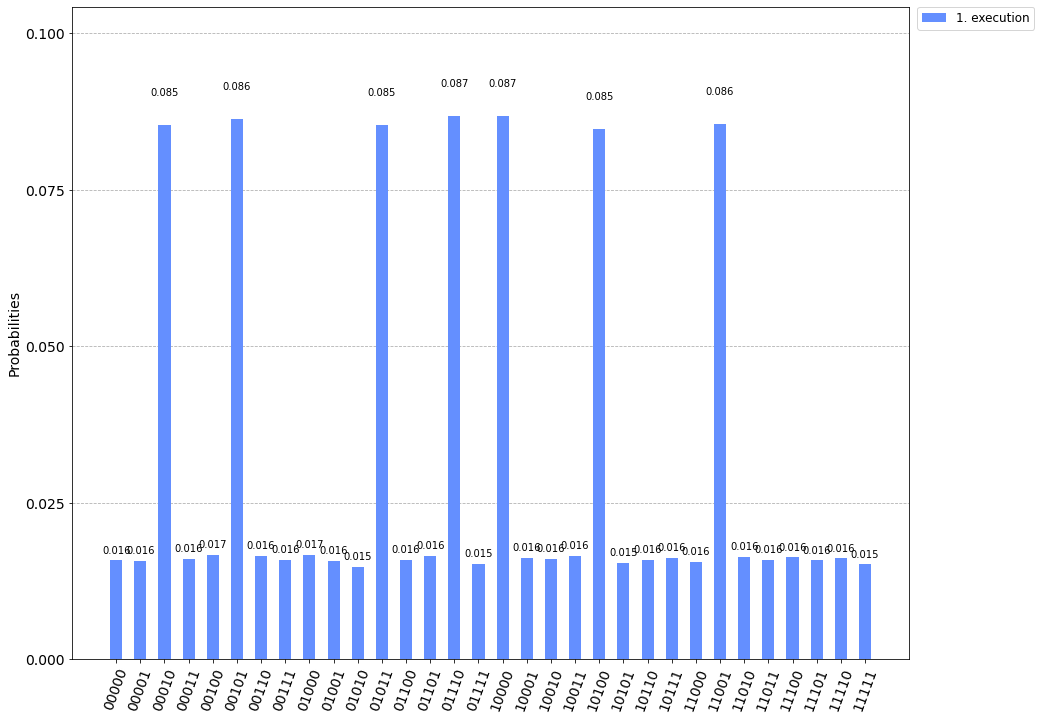

In [22]:
legend = [str(i + 1) + '. execution' for i in range(len(solution_counts))]
plot_histogram(solution_counts, legend=legend, sort='asc', figsize=(15,12))

In [23]:
for counts in solution_counts:
    sorted_counts = dict(sorted(counts.items(), key = lambda item: item[1], reverse=True))
    counts_iterator = iter(sorted_counts)
    print("Possible solution to the Kakuro puzzle: ")
    for i in range(n_variables):
        b = next(counts_iterator)
        (i, j) = state_to_variable(b)
        print("x_" + str(i) + " = " + str(j))
    print()

Possible solution to the Kakuro puzzle: 
x_4 = 0
x_3 = 2
x_1 = 1
x_6 = 1
x_0 = 2
x_2 = 3
x_5 = 0



### Decompose MCX gates for actual Kakuro puzzle

The solution above is easy to understand using multi-control Toffoli gates but since we need to follow the problem definition, we need to decompose the multi-control Toffoli gates into single qubit and CNOT gates. This is something that we already studied in the another challenge. Since the number of ancilla qubits is not restricted now, we can use [this simple decomposition](https://algassert.com/quirk#circuit={%22cols%22:[[%22X%22,%22X%22,%22X%22,%22X%22,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,%22X%22],[1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,%22X%22],[1,1,1,1,%22%E2%80%A2%22,1,1,1,%22X%22],[1,1,1,1,1,1,%22%E2%80%A2%22,1,1,%22X%22],[1,1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,%22X%22],[1,1,1,1,1,%22X%22,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22],[1,1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,%22X%22],[1,1,1,1,1,1,%22%E2%80%A2%22,1,1,%22X%22],[1,1,1,1,%22%E2%80%A2%22,1,1,1,%22X%22],[1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,%22X%22]]}). In the decomposition we still decompose Toffoli-gates. This produces the following code.

In [24]:
def toffoli_decomposed(qc, ctrl_qubits, target):
    first = ctrl_qubits[0]
    second = ctrl_qubits[1]
    
    # I took this decomposition from my solution to multi-control Toffoli challenge
    qc.h(target)
    qc.cx(second, target)
    qc.append(TGate().inverse(), [target])
    qc.cx(first, target)
    qc.append(TGate(), [target])
    qc.cx(first, second)
    qc.cx(second, target)
    qc.cx(first, target)
    qc.append(TGate().inverse(), [second])
    qc.append(TGate().inverse(), [target])
    qc.cx(first, target)
    qc.cx(first, second)
    qc.append(TGate(), [target])
    qc.append(TGate(), [second])
    qc.append(TGate(), [first])
    qc.h(target)
    
    return qc

# This function decomposes Toffoli gate with 5-control qubits
def mcx_5_decomposed(qc, ctrl_qubits, target, ancilla):
    c0, c1, c2 = ctrl_qubits[0], ctrl_qubits[1], ctrl_qubits[2]
    c3, c4 = ctrl_qubits[3], ctrl_qubits[4]
    
    qc = toffoli_decomposed(qc, [c0, c1], ancilla[0])
    #qc.mcx([c0, c1], ancilla[0])
    qc = toffoli_decomposed(qc, [c2, c3], ancilla[1])
    #qc.mcx([c2, c3], ancilla[1])
    qc.cnot(c4, ancilla[2])
    
    qc.cnot(ancilla[0], ancilla[3])
    qc = toffoli_decomposed(qc, [ancilla[1], ancilla[2]], ancilla[4])
    #qc.mcx([ancilla[1], ancilla[2]], ancilla[4])
    
    qc = toffoli_decomposed(qc, [ancilla[3], ancilla[4]], target[0])
    #qc.mcx([ancilla[3], ancilla[4]], target[0])
    
    qc = toffoli_decomposed(qc, [ancilla[1], ancilla[2]], ancilla[4])
    #qc.mcx([ancilla[1], ancilla[2]], ancilla[4])
    qc.cnot(ancilla[0], ancilla[3])
    qc.cnot(c4, ancilla[2])
    qc = toffoli_decomposed(qc, [c2, c3], ancilla[1])
    #qc.mcx([c2, c3], ancilla[1])
    qc = toffoli_decomposed(qc, [c0, c1], ancilla[0])
    #qc.mcx([c0, c1], ancilla[0])
     
    return qc

In [25]:
def compose_grover_oracle2(qc, query_qubits, target_qubit, ancilla_qubits, ctrl_char):
    not_indices = []
    qc.barrier()
    for i, b in enumerate(ctrl_char):
        if b == '0':
            qc.x(query_qubits[len(query_qubits) - i - 1])
            not_indices.append(len(query_qubits) - i - 1)
    
    mcx_5_decomposed(qc, query_qubits, target_qubit, ancilla_qubits)
    
    for i in not_indices:
        qc.x(query_qubits[i])
        
    return qc

In [26]:
if query_qubits == 5:    
    final_circuits = []

    for oracle in oracles:
        
        ancialla_reg = QuantumRegister(5, name = 'ancilla') 
        query_reg = QuantumRegister(query_qubits, name = 'query')
        target_reg = QuantumRegister(1, name = 'target')
        classical_reg = ClassicalRegister(query_qubits)
        
        grover_circuit = QuantumCircuit(query_reg, target_reg, ancialla_reg, classical_reg)
        
        grover_circuit.h(query_reg)
        grover_circuit.x(target_reg)
        grover_circuit.h(target_reg)

        for ctrl_char in oracle['circuit']:
            grover_circuit = compose_grover_oracle2(grover_circuit, query_reg, target_reg, ancialla_reg, ctrl_char)

        grover_circuit.barrier()
        grover_circuit.h(query_reg)
        grover_circuit.h(target_reg)
        grover_circuit.x(query_reg)
        grover_circuit.mcx(query_reg, target_reg[0])
        grover_circuit.x(query_reg)
        grover_circuit.h(query_reg)
        grover_circuit.h(target_reg)
        
        final_circuits.append(grover_circuit)

Uncomment the line if you want to visualize the circuit. It is quite long now.

In [27]:
# final_circuits[0].draw(output = 'mpl')

Then we run the code on the simulator and ensure that the decomposition is correct.

In [28]:
solution_counts = []
for grover_circuit in final_circuits:
    grover_circuit.measure(range(query_qubits), range(query_qubits))
    aer_sim = Aer.get_backend('aer_simulator')
    qobj = assemble(grover_circuit)
    result = aer_sim.run(qobj, shots=100000).result()
    counts = result.get_counts()
    solution_counts.append(counts)

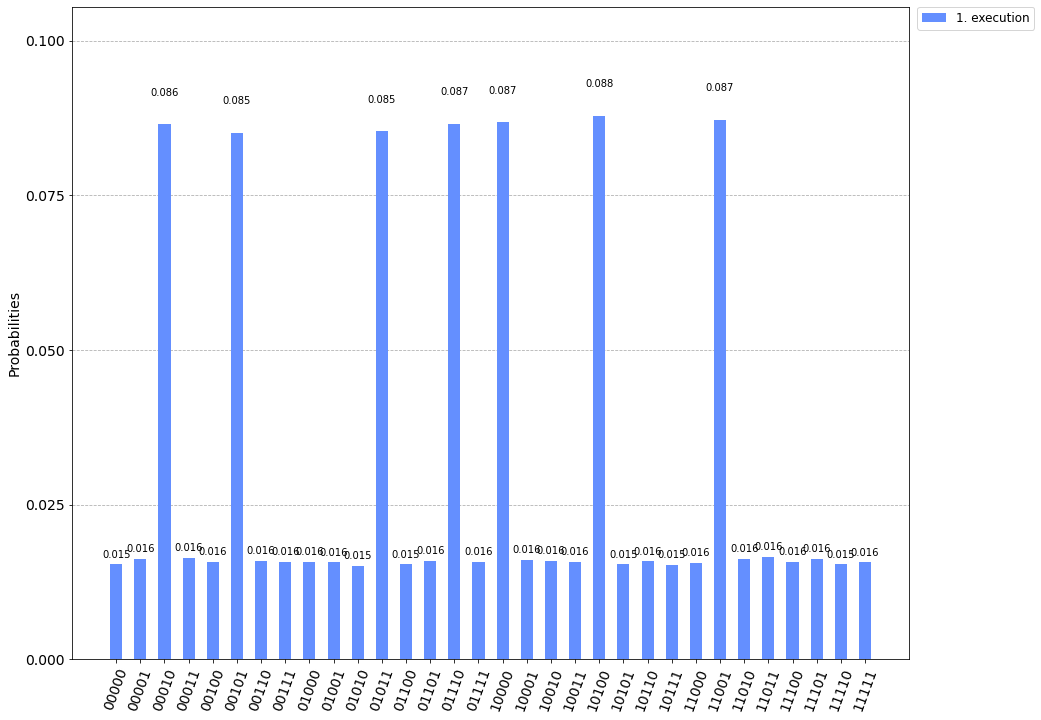

In [29]:
legend = [str(i + 1) + '. execution' for i in range(len(solution_counts))]
plot_histogram(solution_counts, legend=legend, sort='asc', figsize=(15,12))

In [30]:
for counts in solution_counts:
    sorted_counts = dict(sorted(counts.items(), key = lambda item: item[1], reverse=True))
    counts_iterator = iter(sorted_counts)
    print("Possible solution to the Kakuro puzzle: ")
    for i in range(n_variables):
        b = next(counts_iterator)
        (i, j) = state_to_variable(b)
        #print(i,j)
        print("x_" + str(i) + " = " + str(j))
    print()

Possible solution to the Kakuro puzzle: 
x_5 = 0
x_6 = 1
x_4 = 0
x_3 = 2
x_0 = 2
x_2 = 3
x_1 = 1



Statistics about the final decomposed circuit. We can now easily count that there are 371 CNOT gates in the circuit i.e. in the oracle.

In [31]:
final_circuits[0].qasm(filename = 'kakuro_qasm')
print('Gate counts: ', final_circuits[0].count_ops())
print('Depth: ', final_circuits[0].depth())

Gate counts:  OrderedDict([('cx', 371), ('t', 196), ('tdg', 147), ('h', 116), ('x', 51), ('barrier', 8), ('measure', 5), ('mcx_gray', 1)])
Depth:  371


## Solution proposal 2: Apply idea from Qiskit documentation

In this case, we encode the problem using the same binary variables. Following the idea in the [Qiskit documentation](https://qiskit.org/textbook/ch-algorithms/grover.html#sudoku), we can note that the fact $x_0 \neq x_1$ in decimals is equivalent to the fact $x_{0,j} \neq x_{1,j}$ for all $j = 0,1,2,3$ in binary variables. The documentation gives us the following simple circuit that encodes this inequality for each $j = 0, 1, 2, 3$. The idea is that the ancilla qubit is true if one of the variables is true. If both are true, then the ancilla is false.

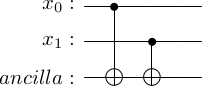

In [32]:
qr = QuantumRegister(2, 'x')
anc = QuantumRegister(1, 'ancilla')
circuit = QuantumCircuit(qr, anc)

circuit.cx(0, 2)
circuit.cx(1, 2)

circuit.draw(output='latex')

For simplicity, let us concentrate on Classiq's specific Kakuro puzzle and not work as general level as in the first case. In the below case, I used all ten constraints without reducing the number manually. In the ancilla qubits, the first index (0-9) refers to the inequality constraint, and the second index refers to the value that the constraint is restricting. 

Then we encode the sums. The idea behind sums is the following: for example, variables $x_2$, $x_3$, $x_4$ can be summed to $5$ with $x_2 = 2$, $x_3 = 3$, $x_4 = 0$. This means that we have the valid case where the binary variables $x_{2,2} = 1$, $x_{3,3} = 1$ and $x_{4,0} = 1$. Each of these binary variables corresponds to a qubit in the above circuit. Thus we can encode this constraint by adding a 3-control qubit Toffoli gate controlled by the qubits corresponding to the variables $x_{2,2}$, $x_{3,3}$ and $x_{4,0}$. That process creates the following circuit. When we mirror the gates to the other side of the last multi-control CNOT gate, we obtain the circuit that works as Grover's oracle. Unfortunately, it is again too large that we could execute it. This approach feels a bit of waste of qubits but I cannot come up how to encode similar idea to phases and use states as in the first solution proposal.

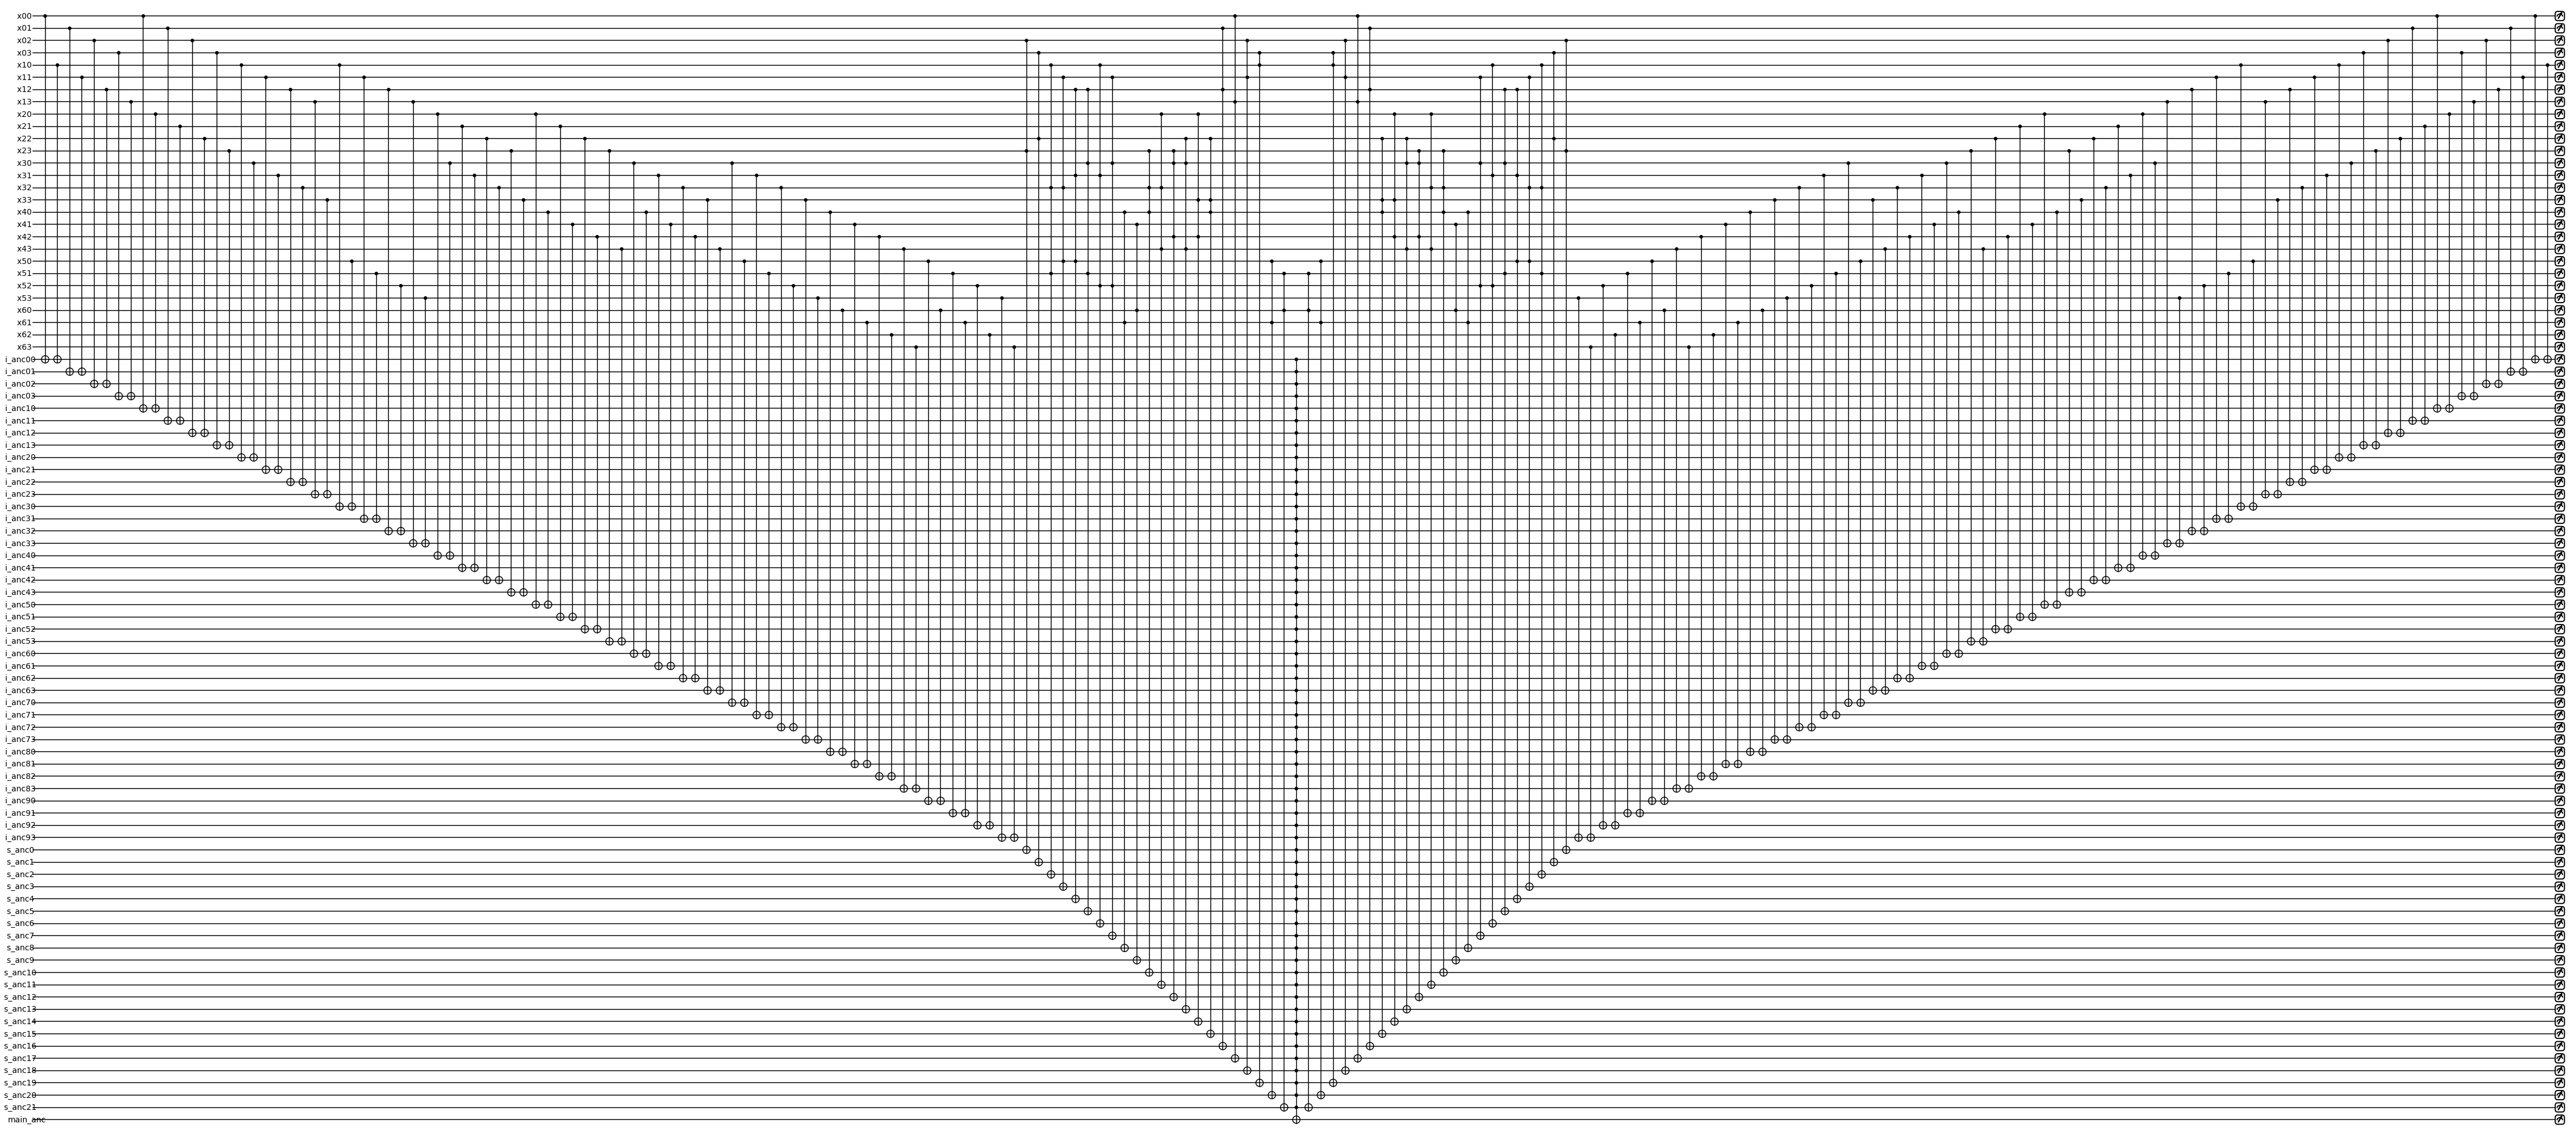

In [33]:
import pennylane as qml
from pennylane import numpy as np

sums = []
for c in sum_equality_constraints:
    sums += sum_options(c)

variable_qubits = ['x' + str(i) + str(j) + '  ' for i in range(n_variables) for j in range(4)]
inequality_ancillas = ['i_anc' + str(i) + str(j) + '     ' for i in range(len(inequality_constraints)) for j in range(4)]
sum_ancillas = ['s_anc' + str(i) + '     ' for i in range(len(sums))]
n_ancilla = len(inequality_ancillas) + len(sum_ancillas)
workwires_for_pennylane = ['qml_wire' + str(i) + '     ' for i in range(10)]
targets = variable_qubits + inequality_ancillas + sum_ancillas+ ['main_anc'] + workwires_for_pennylane

# The circuit is so large that Pennylane's built in devices did not seem to work
# because they are creating some large matrices. Maybe this can be avoided.
# Anyway, Cirq and Braket seemed to work fine

dev = qml.device('cirq.simulator', wires = targets)
#dev = qml.device('braket.local.qubit', wires = targets)

def variables_to_wires(i, j):
    return 4*i + j


def inequality_constraint_circuit(inequality_constraints):
    for i, c in enumerate(inequality_constraints):
        x, y = c[0], c[1]
        for j in range(4):
            x_wire = variables_to_wires(x, j)
            y_wire = variables_to_wires(y, j)
            target_ancilla = inequality_ancillas[4*i + j]
            qml.CNOT(wires = [variable_qubits[x_wire], target_ancilla])
            qml.CNOT(wires = [variable_qubits[y_wire], target_ancilla])
    
    
def inequality_constraint_circuit_reverse(inequality_constraints):
    for i, c in reversed(list(enumerate(inequality_constraints))):
        x, y = c[0], c[1]
        for j in reversed(range(4)):
            x_wire = variables_to_wires(x, j)
            y_wire = variables_to_wires(y, j)
            target_ancilla = inequality_ancillas[4*i + j]
            qml.CNOT(wires = [variable_qubits[x_wire], target_ancilla])
            qml.CNOT(wires = [variable_qubits[y_wire], target_ancilla])

            
def sum_constraint_circuit(sum_equality_constraints):
    ancilla_index = 0
    for c in sum_equality_constraints:
        sums = sum_options(c)
        variables = c['variables']
        for sum_option in sums:
            controls = [variable_qubits[variables_to_wires(variables[k], sum_option[k])] for k in range(len(variables))]
            target_ancilla = sum_ancillas[ancilla_index]
            ancilla_index += 1
            qml.MultiControlledX(wires = controls + [target_ancilla], work_wires = workwires_for_pennylane[:2])
            
            
def sum_constraint_circuit_reverse(sum_equality_constraints):
    ancilla_index = len(sum_ancillas) - 1
    for c in reversed(sum_equality_constraints):
        sums = sum_options(c)
        variables = c['variables']
        for sum_option in reversed(sums):
            controls = [variable_qubits[variables_to_wires(variables[k], sum_option[k])] for k in range(len(variables))]
            target_ancilla = sum_ancillas[ancilla_index]
            ancilla_index -= 1
            qml.MultiControlledX(wires = controls + [target_ancilla], work_wires = workwires_for_pennylane[2:4])

            
@qml.qnode(dev)
def full_grover_oracle(inequality_constraints, sum_equality_constraints):
    inequality_constraint_circuit(inequality_constraints)
    sum_constraint_circuit(sum_equality_constraints)
    qml.MultiControlledX(wires = inequality_ancillas + sum_ancillas + ['main_anc'])
    sum_constraint_circuit_reverse(sum_equality_constraints)
    inequality_constraint_circuit_reverse(inequality_constraints)
    return qml.state()



qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(full_grover_oracle, show_all_wires = False)(inequality_constraints, sum_equality_constraints)
fig.set_size_inches(fig.get_size_inches()[0]*0.3, fig.get_size_inches()[1]*0.3)

Next we can insert the previous Grover oracle in the Grover's algorithm. One solution to the simulation problem might be to note that the oracle does not implement anything which necessarily requires quantum: it is just a sequence of if-then clauses which filps bits. In this sense, we could take some states (possibly those which we consider relevant: the correct solution and a bunch of false solutions) from the initial distribution and then run the oracle with them. If these states indicate that the predicted correct solution has higher probability to be true after a measurement, we could say that the circuit is correct with high probability.

In [34]:
def apply_grover_oracle():
    inequality_constraint_circuit(inequality_constraints)
    sum_constraint_circuit(sum_equality_constraints)
    qml.MultiControlledX(wires = inequality_ancillas + sum_ancillas + ['main_anc'], work_wires = workwires_for_pennylane[4:8])
    sum_constraint_circuit_reverse(sum_equality_constraints)
    inequality_constraint_circuit_reverse(inequality_constraints)
    
    
def apply_diffusion():
    qml.broadcast(qml.Hadamard, variable_qubits + ['main_anc'], pattern = 'single')
    qml.MultiControlledX(control_wires = variable_qubits, wires = ['main_anc'], control_values = '0'*(len(variable_qubits)), work_wires = workwires_for_pennylane[8:10])
    qml.broadcast(qml.Hadamard, variable_qubits + ['main_anc'], pattern = 'single')

    
@qml.qnode(dev)
def full_grover2():
    qml.PauliX(wires = ['main_anc'])
    qml.broadcast(qml.Hadamard, variable_qubits + ['main_anc'], pattern = 'single')
    apply_grover_oracle()
    apply_diffusion()
    
    return qml.probs(wires = variable_qubits)

The following code draws the whole Grover search circuit:

In [35]:
#qml.drawer.use_style('black_white')
#fig, ax = qml.draw_mpl(full_grover2, show_all_wires = False)()
#fig.set_size_inches(fig.get_size_inches()[0]*0.3, fig.get_size_inches()[1]*0.3)
#print(full_grover2())

## Solution proposal 3: Apply ideas from paper _Grover Adaptive Search for Constrained Polynomial Binary Optimization_

### Encode constraints as QUBO

Again, we encode the variables and values using the binary variables $x_{i,j}$. The idea is to define an objective function

$$
f(x) = \sum_{i,j = 0}^{n}a_{i,j}x_ix_j + \sum_{i = 0}^{n}b_{i}x_i + c
$$

so that we find its minimum and the binary values, which minimize the function. When the objective function is constructed to implement the constraints of the Kakuro problem, it heuristically solves the problem. The easiest method is to use quantum annealing but based on the paper [Grover Adaptive Search for Constrained Polynomial Binary Optimization](https://arxiv.org/abs/1912.04088), we should be able to solve the problem with a novel application of Grover Search. Since QUBOs are strongly connected to quantum annealing, the most convenient framework to use here is D-wave's Ocean package.

#### Objective function for inequality constraints

For example, the constraint $x_0 \neq x_1$ means that for any $j = 0,1,2,3$, if $x_{0,j} = 1$ then $x_{1,j} = 0$. In this case the objective function reaches the correct minimum when we add term $x_{0,j}x_{1,j}$ for each $j = 0,1,2,3$. Thus we construct of QUBO which consists of terms as $x_{0,j}x_{1,j}$ encoding the inequality constraints.

In [36]:
import dimod
from dimod.generators.constraints import combinations as qubo_combinations
from dwave.system import LeapHybridSampler
from hybrid.reference import KerberosSampler
from dwave.system.composites import EmbeddingComposite

from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

# Some helper functions
def append_linear_safe(var, val, linear):
    if var in linear.keys():
        linear[var] = linear[var] + val
    else:
        linear[var] = val

def append_quadratic_safe(var, val, quadratic):
    if var in quadratic.keys():
        quadratic[var] = quadratic[var] + val
    else:
        quadratic[var] = val

In [37]:
def construct_bqm_constraint1(bqm, inequality_constraints):
    vartype = dimod.BINARY
    A = 1
    linear = dict()
    quadratic = dict()
    offset = 0.0

    for c in inequality_constraints:
        x, y = c[0], c[1]
        for j in range(4):
            var1, var2 = (x,j), (y,j)
            append_quadratic_safe((var1, var2), 1, quadratic)

    bqm_c1 = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)
    bqm_c1.scale(A)
    bqm.update(bqm_c1)
    return bqm

#### Objective function for sum constraints

The following formulation follows from the facts on how we can divide the sum constraints based on the `sum_options` function. Designing this objective function requires a bit of manual work because the squared terms need to be opened before we can input them. That is why some constants and coefficients (-11 and 36) appear to come out of the blue.

In [38]:
from itertools import combinations

def construct_bqm_constraint2(bqm, sum_equality_constraints):
    vartype = dimod.BINARY
    A = 10
    linear = dict()
    quadratic = dict()
    offset = 4

    for c in sum_equality_constraints:
        bin_variables = []
        variables = c['variables']
        options = sum_options(c)
        
        for i, var in enumerate(variables):
            for o in options:
                bin_variables.append((var, o[i]))
        
        offset = 4
        linear_coefficient = -3   

        if len(variables) == 3:
            offset = 36
            linear_coefficient = -11

        for b in bin_variables:
            append_linear_safe(b, linear_coefficient, linear)

        for comb in combinations(bin_variables, 2):
            append_quadratic_safe(comb, 2, quadratic)

    bqm_c2 = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)
    bqm_c2.scale(A)
    bqm.update(bqm_c2)
    return bqm

#### Additional constraints

For every $i$ there is exactly one $j$ so that $x_{i,j} = 1$.

In [39]:
def construct_bqm_constraint3(bqm, n_variables):
    strength = 40.0
    for x in range(n_variables):
        variables = [(x, j) for j in range(4)]
        bqm3 = qubo_combinations(variables, 1, strength=strength)
        bqm.update(bqm3)
    return bqm

### Demonstration on minimizing objective function with Amazon Braket, D-wave Leap and local machine

In [40]:
vartype = dimod.BINARY
bqm = dimod.BinaryQuadraticModel({}, {}, 0.0, vartype)

bqm = construct_bqm_constraint1(bqm, inequality_constraints)
bqm = construct_bqm_constraint2(bqm, sum_equality_constraints)
bqm = construct_bqm_constraint3(bqm, n_variables)

In [41]:
def solve_bqm_in_Amazon_Braket(bqm, system = "Advantage"):
    device = None
    num_reads = 10000
    if system == "Advantage":
        device = "arn:aws:braket:::device/qpu/d-wave/Advantage_system4"
    elif system == "2000Q":
        device = "arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6"
    sampler = BraketDWaveSampler(device_arn = device)
    sampler = EmbeddingComposite(sampler)
    sampleset = sampler.sample(bqm, num_reads=num_reads)
    sample = sampleset.first.sample
    
    # print timing info for the previous D-Wave job
    print(sampleset.info['additionalMetadata']['dwaveMetadata']['timing'])
    
    return sample

In [42]:
def solve_exactly(bqm):
    sampler = dimod.ExactSolver()
    sampleset = sampler.sample(bqm)
    sample = sampleset.first.sample
    return sample

Now we hopefully get the correct result. I run the code on Amazon Braket:

In [43]:
#result = solve_bqm_in_Amazon_Braket(bqm)

#for elem in result:
#    if result[elem] == 1:
#        print('x_' + str(elem[0]) + ' = ' + str(elem[1]))

I got the following result from Amazon Braket:

```
{'qpuSamplingTime': 1429400, 'qpuAnnealTimePerSample': 20, 'qpuAccessTime': 1444466, 'qpuAccessOverheadTime': 10467, 'qpuReadoutTimePerSample': 102, 'qpuProgrammingTime': 15066, 'qpuDelayTimePerSample': 20, 'postProcessingOverheadTime': 3454, 'totalPostProcessingTime': 29876, 'totalRealTime': None, 'runTimeChip': None, 'annealTimePerRun': None, 'readoutTimePerRun': None}

x_0 = 2
x_1 = 0
x_2 = 3
x_3 = 2
x_4 = 0
x_5 = 1
x_6 = 0

```

In [44]:
def solve_bqm_in_leap(bqm, sampler = "Kerberos"):
    bqm.normalize()
    if sampler == "Kerberos":
        kerberos_sampler = KerberosSampler().sample(bqm, max_iter=10, convergence=3, qpu_params={'label': 'Kakuro puzzle'})
        sample = kerberos_sampler.first.sample
    elif sampler == "LeapHybrid":
        sampler = LeapHybridSampler()
        sampleset = sampler.sample(bqm)
        sample = sampleset.first.sample
    return sample

With D-wave's Leap we obtain the correct result as well:

In [45]:
#result = solve_bqm_in_leap(bqm, sampler = "LeapHybrid")

#for elem in result:
#    if result[elem] == 1:
#        print('x_' + str(elem[0]) + ' = ' + str(elem[1]))

In the case you don't have access to Amazon Braket or D-wave Leap, you can also use the local classical simulated annealing module. Unfortunately this one is usually relatively slow before we start getting good results, for example, we had 10 000 num_reads on the quantum computer and 1000 on the local machine. But it seems that 1000 shots is not enough for the classical simulated annealing. Anyway, the quality depends a lot on the parameters and the parameters are sometimes difficult to find (or I have not learned that yet).

In [46]:
def solve_with_simulated_annealing(bqm):
    sampler = dimod.SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=1000)
    sample = sampleset.first.sample
    return sample

In [47]:
#result = solve_with_simulated_annealing(bqm)

#for elem in result:
#    if result[elem] == 1:
#        print('x_' + str(elem[0]) + ' = ' + str(elem[1]))

### Solve QUBO with Grover Adaptive Search

The previous example showed how easy it is to solve the problem with quantum annealing. We can be sure that the objective function we found is correct. Next, we study if we can perform something similar to the annealing using Grover's Adaptive Search algorithm. A general version of the algorithm is implemented in [Qiskit Optimization package](https://github.com/qiskit/qiskit-optimization), and a concrete example can be found in the [Grover Optimizer](https://qiskit.org/documentation/optimization/tutorials/04_grover_optimizer.html) tutorial. 

I would like to understand the algorithm better, so I started to open and apply the code from [Source code for qiskit.circuit.library.arithmetic.quadratic_form](https://qiskit.org/documentation/_modules/qiskit/circuit/library/arithmetic/quadratic_form.html#QuadraticForm) and from [grover_optimizer.py](https://github.com/Qiskit/qiskit-optimization/blob/098c167a07e6ed23915ee14c8f3695bf1ced32c4/qiskit_optimization/algorithms/grover_optimizer.py). This code is in kakuro_GAS_draft notebook. I could not finish that part in time. It is easy to use the Qiskit Optimization package to solve the QUBO we previously obtained. Unfortunately, the circuit is large again, see the example in the Kakuro_GAS.txt file. 100 qubit simulator accepts the optimization problem, but the circuit is too deep, so it could not finish with it. I still believe that the method produces a correct result for the Kakuro puzzle because the objective function is correct, as Braket and Leap analysis showed, and Qiskit's GroverOptimizer must work.

IBM Quantum produces a sort of QASM file of the circuit that it runs, and this file is `IBM_quantum_GAS_input.json` in this repository. There are 10 827 instructions. GroverOptimizer module does not allow access to the circuit which optimizes the quadratic program.

In [ ]:
from qiskit_optimization import QuadraticProgram
from qiskit import BasicAer
from qiskit_optimization.algorithms import GroverOptimizer
from qiskit.providers.ibmq import least_busy

TOKEN = "add your token"
IBMQ.save_account(TOKEN, overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('simulator_mps')

qiskit_bqm = QuadraticProgram()

for var in bqm.variables:
    qiskit_bqm.binary_var(str(var))

constant = bqm.offset
linear = []
quadratic = {}

for var in bqm.variables:
    linear.append(bqm.linear[var])
    
for key in bqm.quadratic:
    quadratic[(str(key[0]), str(key[1]))] = bqm.quadratic[key]

qiskit_bqm.minimize(constant = constant, linear=linear, quadratic=quadratic)

grover_optimizer = GroverOptimizer(15, num_iterations=2, quantum_instance=backend)
results = grover_optimizer.solve(qiskit_bqm)

print("x={}".format(results.x))
print("fval={}".format(results.fval))